In [81]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Data Preprocessing 

##### since there was no header, I added one with generic names

In [82]:
col_names = ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'target']
df = pd.read_csv('../data/crx.data', names=col_names)
df.head()


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,target
b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 690 entries, b to b
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   feature_1   690 non-null    object 
 1   feature_2   690 non-null    float64
 2   feature_3   690 non-null    object 
 3   feature_4   690 non-null    object 
 4   feature_5   690 non-null    object 
 5   feature_6   690 non-null    object 
 6   feature_7   690 non-null    float64
 7   feature_8   690 non-null    object 
 8   feature_9   690 non-null    object 
 9   feature_10  690 non-null    int64  
 10  feature_11  690 non-null    object 
 11  feature_12  690 non-null    object 
 12  feature_13  690 non-null    object 
 13  feature_14  690 non-null    int64  
 14  target      690 non-null    object 
dtypes: float64(2), int64(2), object(11)
memory usage: 86.2+ KB


##### the first thing I notice while looking at the statistical measures is the standard deviation for feature 14.
##### such a high value (compared to the mean) indicates that outliers are affecting the scale, and this should be addressed later on.

##### another thing I'm noticing is the quantity of zeros in the numerical columns, maybe the zeros are representing missing data. It's hard to say without knowing the context of each column, but it's something I should keep in mind

In [84]:
df.describe()

,feature_2,feature_7,feature_10,feature_14
count,690.000000,690.000000,690.00000,690.000000
mean,4.758725,2.223406,2.40000,1017.385507
std,4.978163,3.346513,4.86294,5210.102598
min,0.000000,0.000000,0.00000,0.000000
25%,1.000000,0.165000,0.00000,0.000000
50%,2.750000,1.000000,0.00000,5.000000
75%,7.207500,2.625000,3.00000,395.500000
max,28.000000,28.500000,67.00000,100000.000000


## missing data

##### first step is to check if there are any missing data

In [85]:
df.isna().sum()

feature_1     0
feature_2     0
feature_3     0
feature_4     0
feature_5     0
feature_6     0
feature_7     0
feature_8     0
feature_9     0
feature_10    0
feature_11    0
feature_12    0
feature_13    0
feature_14    0
target        0
dtype: int64

##### while looking through the dataset I found that the symbol "?" is representing the missing data instead of NaN
##### so the next step is to count how many "?" are there, this should be done in every categorical column, since the numerical columns don't accept such symbols

In [86]:

categorical_columns = df.select_dtypes(include=['object', 'category']).columns
for column in categorical_columns:
    value_counts = df[column].value_counts()
    question_mark_count = value_counts.get('?', 0)
    print(column, ':', question_mark_count)
    


feature_1 : 12
feature_3 : 6
feature_4 : 6
feature_5 : 9
feature_6 : 9
feature_8 : 0
feature_9 : 0
feature_11 : 0
feature_12 : 0
feature_13 : 13
target : 0


##### since I found a small number of missing values, I think it's safe to drop them without losing too much data

In [87]:
# drop missing data
for column in categorical_columns:
    has_question_mark = df[column].isin(['?']).any()
    if has_question_mark > 0:
        df[column] = df[column].replace('?', np.nan)
        #df[column] = df[column].fillna(method='ffill')
        df[column].dropna()

## outliers

##### I think column feature_14 has significant outliers, as I said while looking at the statistical values.
##### I ploted the distribution to get more insight in this, and since it's highly concentrated around zero, but has a sharp drop, it suggests that outliers are in fact afecting the distribuition.

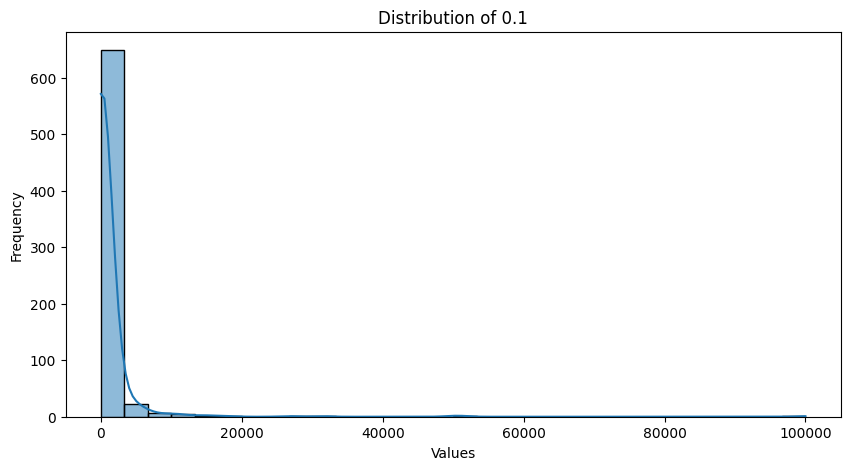

In [88]:
plt.figure(figsize=(10,5))
sns.histplot(df['feature_14'], kde= True, bins=30)
plt.title('Distribution of 0.1')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

##### I also ploted a boxplot, to better visualize the outliers
##### the majority of the data in concentraded near zero, but the are some points going as far as 100,000
##### I think its safe to say that I need to alter the scale or remove the outliers. 

Text(0.5, 0, 'Values')

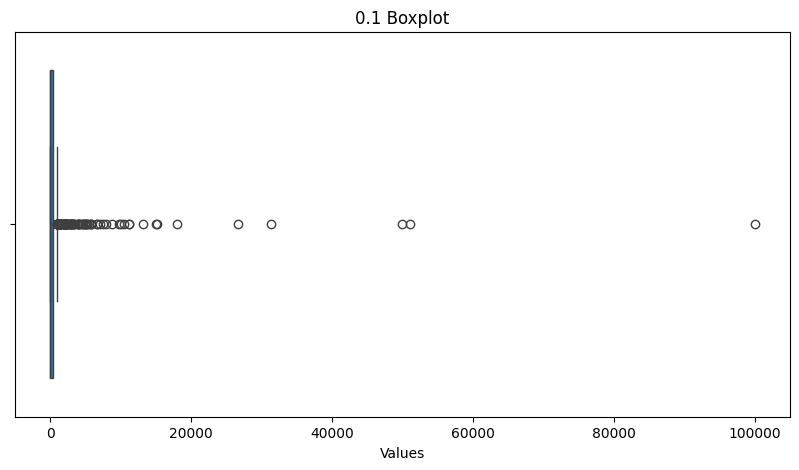

In [89]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df['feature_14'])
plt.title('0.1 Boxplot')
plt.xlabel('Values')

##### I also checked the skew value to confirm the presence of asymmetry in the distribution.

In [90]:
df['feature_14'].skew()

np.float64(13.140655014445459)

### to deal with this issue I'm trying two approaches, removing the outliers or altering the scale

### removing outliers using IQR

In [91]:
Q1 = df['feature_14'].quantile(0.25)
Q3 = df['feature_14'].quantile(0.75)

IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

df_filtered_IQR = df[~((df['feature_14'] < lower_limit) | (df['feature_14'] > upper_limit))]

df_filtered_IQR.shape

(577, 15)

##### to check if this approach worked, I plotted the boxplot again, and I think the distribution has improved significantly. 
##### however, there are still some values that are quite far from the rest

Text(0.5, 0, 'Values')

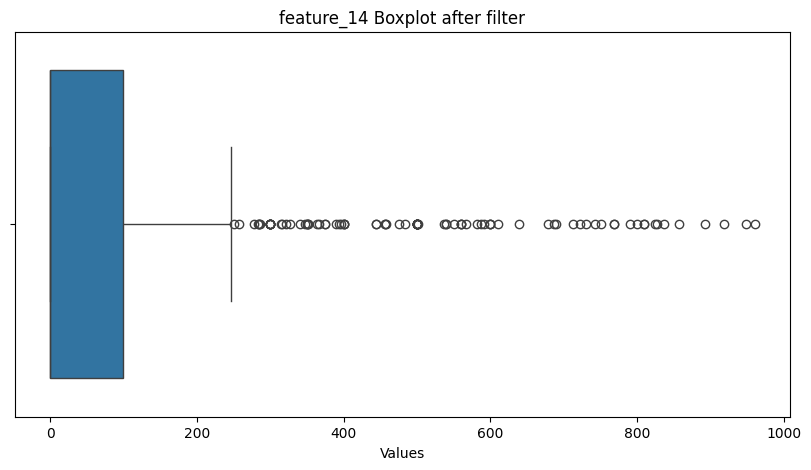

In [92]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df_filtered_IQR['feature_14'])
plt.title('feature_14 Boxplot after filter')
plt.xlabel('Values')

### treating outliers with log transformation

In [93]:
df['feature_14_log'] = np.log1p(df['feature_14'])

##### plotting the boxplot again revealed that the log transformation approach worked better, indicating that altering the scale was a more effective solution

Text(0.5, 0, 'Values')

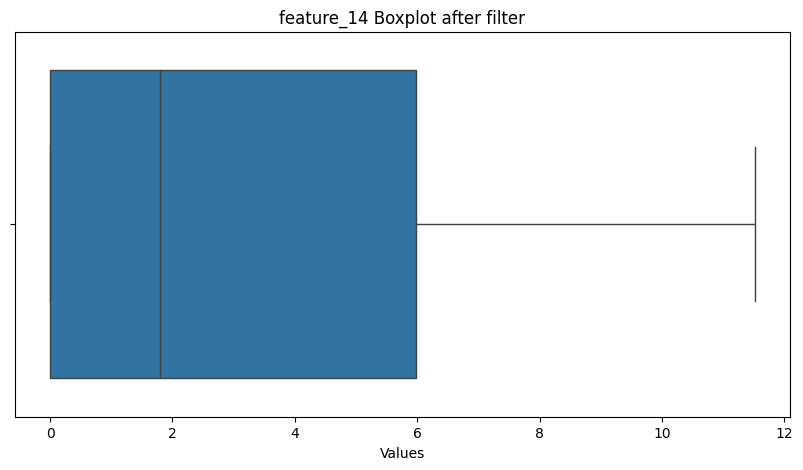

In [94]:
plt.figure(figsize=(10,5))
sns.boxplot(x= df['feature_14_log'])
plt.title('feature_14 Boxplot after filter')
plt.xlabel('Values')

#### checking the statistical measures again, the standard deviation and mean values appear more as expected.

In [95]:
df.describe()

,feature_2,feature_7,feature_10,feature_14,feature_14_log
count,690.000000,690.000000,690.00000,690.000000,690.000000
mean,4.758725,2.223406,2.40000,1017.385507,2.972321
std,4.978163,3.346513,4.86294,5210.102598,3.188431
min,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1.000000,0.165000,0.00000,0.000000,0.000000
50%,2.750000,1.000000,0.00000,5.000000,1.791759
75%,7.207500,2.625000,3.00000,395.500000,5.982674
max,28.000000,28.500000,67.00000,100000.000000,11.512935


##### now I can drop the feature_14 column, since I'm going to use only the feature_14_log from now on

In [96]:
df = df.drop(columns=['feature_14'])
df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,target,feature_14_log
b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,+,0.000000
a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,+,6.329721
a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,+,6.715383
b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,+,1.386294
b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,+,0.000000
